In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 14-1 差分画像を用いた移動体検出
## 14-1-1 差分画像
---
2枚の画像において、同じ位置にある画素値の差の絶対値の画像を**差分画像**と呼ぶ。

## 14-1-2 背景差分法
---
**背景差分法**による移動体検出は以下のように行われる。  
移動物体がない状態の画像を固定カメラで背景画像として取り込み、移動物体が入った画像から背景画像を差分し、差分画像を得る。  
つぎに、この差分画像にしきい値処理を行い、2値化画像を得る。  
小さな穴や連結部分をクロージング・オープニングで取り除き、移動物体の領域を得る。  
この2値化画像をを利用して対象物体の位置する画素を取り出すことで、移動体の画像を得る。

In [18]:
def read_img(name):
    img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/"+name+".jpg")
    h, w = img_bgr.shape[:2]
    scale = (640 * 480 / (w * h)) ** 0.5
    img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
    img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)
    return img_rgb, img_gray

img_rgb1, img_gray1 = read_img('img1')
img_rgb2, img_gray2 = read_img('img2')
img_rgb3, img_gray3 = read_img('img3')
img_rgb4, img_gray4 = read_img('img4')

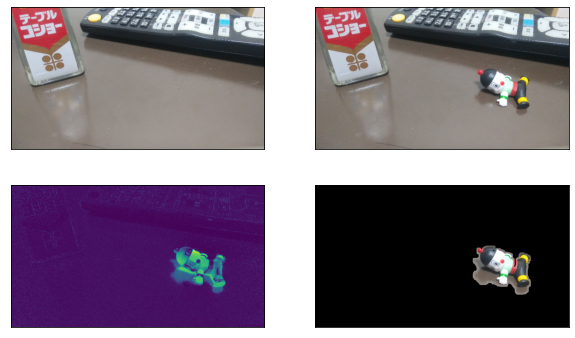

In [4]:
kernel = np.ones((3, 3), np.uint8)

# 差分・2値化
diff = cv2.absdiff(img_gray1, img_gray2)
ret, thresh = cv2.threshold(diff, 15, 255, cv2.THRESH_BINARY)

# オープニング
thresh = cv2.erode(thresh, kernel, iterations = 1)
thresh = cv2.dilate(thresh, kernel, iterations = 5)
thresh = np.array([thresh,thresh,thresh]).transpose(1, 2, 0)

# マスク処理
dst = cv2.bitwise_and(img_rgb2, thresh)

fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0][0].imshow(img_rgb1)
ax[0][0].set_xticks([]);
ax[0][0].set_yticks([]);

ax[0][1].imshow(img_rgb2)
ax[0][1].set_xticks([]);
ax[0][1].set_yticks([]);

ax[1][0].imshow(diff)
ax[1][0].set_xticks([]);
ax[1][0].set_yticks([]);

ax[1][1].imshow(dst)
ax[1][1].set_xticks([]);
ax[1][1].set_yticks([]);

## 14-1-3 フレーム間差分法
---
理想的な背景画像が得られない場合、移動物体を撮影した異なる時間の3枚の画像を用いて移動物体領域を取り出す方法がある。  
これを**フレーム間差分法**と呼ぶ。  
3枚の画像A,B,Cに対してまずAとB、BとCの差分画像を作成し、しきい値処理で2値画像を得る。  
それらの論理積処理から、共通領域を取り出すことで、画像Bにおける移動物体の領域を得ることができる。

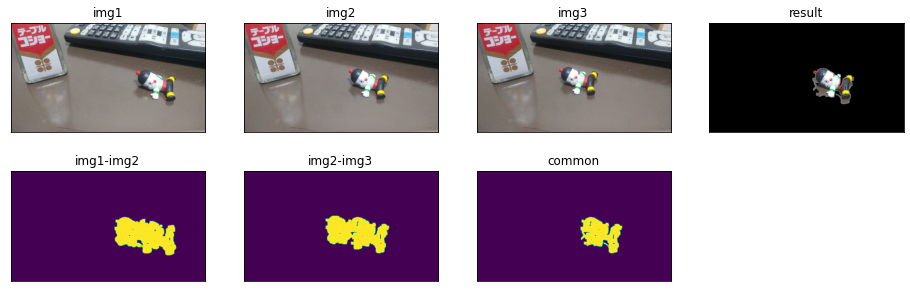

In [5]:
diff1 = cv2.absdiff(img_gray2, img_gray3)
diff2 = cv2.absdiff(img_gray3, img_gray4)

ret, thresh1 = cv2.threshold(diff1, 15, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(diff2, 15, 255, cv2.THRESH_BINARY)

thresh1 = cv2.erode(thresh1, kernel, iterations = 2)
thresh1 = cv2.dilate(thresh1, kernel, iterations = 4)

thresh2 = cv2.erode(thresh2, kernel, iterations = 2)
thresh2 = cv2.dilate(thresh2, kernel, iterations = 4)

mask = cv2.bitwise_and(thresh1, thresh2)
mask = np.array([mask,mask,mask]).transpose(1, 2, 0)

dst = cv2.bitwise_and(img_rgb3, mask)

fig, ax = plt.subplots(2, 4, figsize=(16, 5))

ax[0][0].imshow(img_rgb2);
ax[0][0].set_xticks([]);
ax[0][0].set_yticks([]);
ax[0][0].set_title("img1");

ax[0][1].imshow(img_rgb3);
ax[0][1].set_xticks([]);
ax[0][1].set_yticks([]);
ax[0][1].set_title("img2");

ax[0][2].imshow(img_rgb4);
ax[0][2].set_xticks([]);
ax[0][2].set_yticks([]);
ax[0][2].set_title("img3");

ax[0][3].imshow(dst);
ax[0][3].set_xticks([]);
ax[0][3].set_yticks([]);
ax[0][3].set_title("result");

ax[1][0].imshow(thresh1);
ax[1][0].set_xticks([]);
ax[1][0].set_yticks([]);
ax[1][0].set_title("img1-img2");

ax[1][1].imshow(thresh2);
ax[1][1].set_xticks([]);
ax[1][1].set_yticks([]);
ax[1][1].set_title("img2-img3");

ax[1][2].imshow(mask[:,:,0]);
ax[1][2].set_xticks([]);
ax[1][2].set_yticks([]);
ax[1][2].set_title("common");

ax[1][3].axis('off');

## 14-1-4 統計的背景差分法
---
背景として取り込まれた画像の画素値には時間的な変動があるため、それが移動体として検出されてしまう。  
このような画素値の定常的な変動を考慮して移動物体を検出する方法に**統計的背景差分法**がある。  
背景に関する画素のクラスを$\omega_{0}$とし、移動物体に属する画素のクラスを$\omega_{1}$とする。  
ある画素の画素値が$I$のとき、その画素が$\omega_{0}$に属する確率を$p(\omega_{0}|I)$とし、$\omega_{1}$に属する確率を$p(\omega_{1}|I)$とする。  
$$p(\omega_{0}|I)=\frac{p(\omega_{0})p(I|\omega_{0})}{p(I)}$$
$$p(\omega_{1}|I)=\frac{p(\omega_{1})p(I|\omega_{1})}{p(I)}$$
$p(\omega_{1}|I)$が大きければ画素は移動物体に属すると判定する。  
ここで、
$$p(I|\omega_{0})=\frac{q(I)}{\sum_{I=0}^{255}q(I)}$$
$$p(I|\omega_{1})=\frac{1}{255}$$
とする。  
また、$p(\omega_{0}),p(\omega_{1})$が計算できない場合は、$p(\omega_{0})=p(\omega_{1})=0.5$とする。

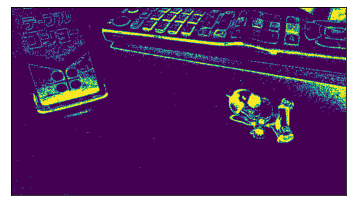

In [6]:
n_bins = 256  # ビンの数
hist_range = [0, 256]  # 集計範囲

hist = cv2.calcHist([img_gray1.astype('uint8')], channels=[0], mask=None, histSize=[n_bins], ranges=hist_range)

hist_norm = hist / hist.sum()
hist_norm = hist_norm.squeeze(axis=-1)

p_I_w0 = hist_norm
p_I_w1 = 1 / 256
p_w0 = 0.8
p_w1 = 0.2

I1 = p_I_w0[img_gray2]*p_w0/(p_I_w0[img_gray2]*p_w0+p_I_w1*p_w1)
I2 = p_I_w1*p_w1/(p_I_w0[img_gray2]*p_w0+p_I_w1*p_w1)

plt.imshow(I1<I2);
plt.xticks([]);
plt.yticks([]);

### OenCVによる背景差分

In [7]:
cap = cv2.VideoCapture("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/20181225_111451.avi")

fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
#fgbg = cv2.createBackgroundSubtractorMOG2()
#fgbg = cv2.bgsegm.createBackgroundSubtractorCNT()
#fgbg = cv2.bgsegm.createBackgroundSubtractorGSOC()
#fgbg = cv2.bgsegm.createBackgroundSubtractorLSBP()
#fgbg = cv2.createBackgroundSubtractorKNN()
#fgbg = cv2.bgsegm.createBackgroundSubtractorGMG()

while(1):
    ret, frame = cap.read()

    fgmask = fgbg.apply(frame)

    cv2.imshow('frame',fgmask)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

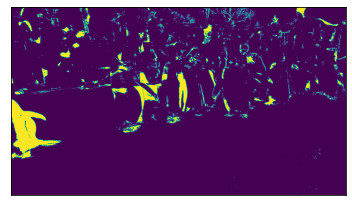

In [8]:
plt.imshow(fgmask);
plt.xticks([]);
plt.yticks([]);

# 14-2 オプティカルフロー
## 14-2-1 オプティカルフローの求め方
---
**オプティカルフロー**とは、対象物体やカメラの移動によって、生じる画像フレーム間の対象物体の動きや見え方の変化のパターンを、  
フレーム間の画素の変位の2次元ベクトルで表現するものである。  
画素を中心とした、小領域の画像を用いて求める。  
移動量が大きい場合はブロックマッチング法、微小な場合は勾配法を用いる。

## 14-2-2 ブロックマッチング法
---
**ブロックマッチング法**とは、テンプレートマッチングを用いてオプティカルフローを求める方法である。

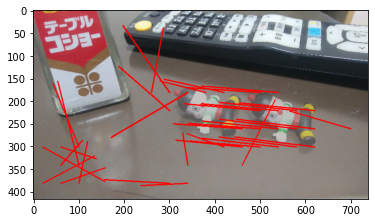

In [9]:
def block_match(x, y, before, after, pad):
    x1 = x
    y1 = y

    templ = before[(x1-pad):(x1+pad),(y1-pad):(y1+pad),:]
    test = after.copy()

    result = cv2.matchTemplate(test, templ, cv2.TM_CCOEFF_NORMED)
    mmr = cv2.minMaxLoc(result)
    pos = mmr[3]

    posy, posx = pos[0] + templ.shape[1]//2, pos[1] + templ.shape[0]//2
    return posx, posy

dst = cv2.addWeighted(img_rgb2, 0.5, img_rgb4, 0.5, 0)

pad = 20
xrange = np.arange(pad+1, img_rgb2.shape[0]-pad, pad*2)
yrange = np.arange(pad+1, img_rgb2.shape[1]-pad, pad*2)

for i in xrange:
    for j in yrange:
        pos = block_match(i, j, img_rgb2, img_rgb4, pad)
        dist = np.sqrt((pos[0]-i)**2+(pos[1]-j)**2)
        
        if (dist >= 200)|(dist<=20):
            continue
        else:        
            cv2.line(dst, (j,i),(pos[1],pos[0]), (255, 0, 0), 2)

plt.imshow(dst)

## 14-2-3 勾配法
---
連続する2枚の画像での対象物の移動量が微小であることを前提にオプティカルフローを求める方法を**勾配法**と呼ぶ。  
画像上の画素$(x,y)$の時刻$t$における画素値を$I(x,y,t)$とし、時間$\Delta t$の間にその画素が$(\Delta x,\Delta y)$だけ移動したとする。  
その画素値は変化しないと期待できることから、以下が成り立つ。
$$I(x,y,t)=I(x+\Delta x, y+\Delta y,t+\Delta t)$$
テイラー展開すし、両辺を$\Delta t$で割り、整理すると以下が得られる。
$$I(x,y,t) \fallingdotseq I(x,y,t)+\frac{\partial I}{\partial x}+\frac{\partial I}{\partial y}+\frac{\partial I}{\partial t}$$
$$\frac{\partial I}{\partial x}\frac{\Delta x}{\Delta t}+\frac{\partial I}{\partial y}\frac{\Delta y}{\Delta t}+\frac{\partial I}{\partial t}=0$$
微小な時間の微小な移動であることから、
$$\frac{\partial I}{\partial x}\frac{\partial x}{\partial t}+\frac{\partial I}{\partial y}\frac{\partial y}{\partial t}+\frac{\partial I}{\partial t}=0$$
ここで、オプティカルフローを$(u,v)=(\frac{\partial x}{\partial t}, \frac{\partial y}{\partial t})$とし、  
画像上の画素値のx方向およびy方向の偏微分をそれぞれ$I_{x},I_{y}$とし、時間偏微分を$I_{t}$とすると、以下となる。
$$I_{x}u+I_{y}v+I_{t}=0$$
これを、**オプティカルフローの拘束条件式**と呼ぶ。
### Lucas-Kanadeの方法(LK法)  
近傍の複数($m=n×n$)の画素で同一のオプティカルフローが得られるとすると、以下が得られる。
$$\boldsymbol{Gf}+\boldsymbol{b}=0$$
$$
    \boldsymbol{G}=
    \left[\begin{array}{cc}
    I_{x1}&I_{y1}\\
    \vdots&\vdots\\
    I_{xm}&I_{ym}
    \end{array}\right],\:
    \boldsymbol{f} =
    \left[\begin{array}{c}
    u\\
    v
    \end{array}\right],\:
    \boldsymbol{b} =
    \left[\begin{array}{c}
    I_{t1}\\
    \vdots\\
    I_{tm}
    \end{array}\right]
$$
以下のように最小二乗法の意味で最適な$(u,v)$が求まる。
$$\boldsymbol{f}=-(\boldsymbol{G}^{T}\boldsymbol{G})^{-1}\boldsymbol{G}^{T}\boldsymbol{b}$$

In [32]:
cap = cv2.VideoCapture("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/20181225_111451.avi")

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret,frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cv2.destroyAllWindows()
cap.release()

<ipython-input-32-f2ec77b7e9e3>:40: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
<ipython-input-32-f2ec77b7e9e3>:41: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)


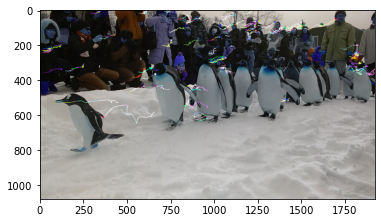

In [39]:
plt.imshow(img)

In [13]:
cap = cv2.VideoCapture("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/20181225_111451.avi")

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',rgb)
    prvs = next

cap.release()
cv2.destroyAllWindows()

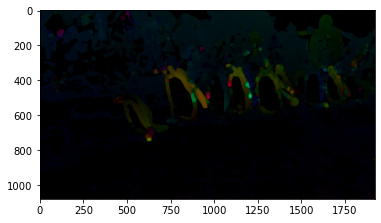

In [15]:
plt.imshow(rgb)

# 14-3 物体追跡
## 14-3-1 物体追跡の手法分類
---
物体が次のフレームでどこへ移動したのかを見つける方法として、  
1. 近傍を全探索する方法  
2. 移動体のあった位置を中心に特徴の局所変化方向を追跡する方法  
3. 移動体の動きから次の移動位置を予測して探索する方法  

の3種類がある。  
また、追跡方法に、移動体の画像そのものを使う方法、移動体の特徴量を使う方法、移動体の一部の特徴点を使う方法がある。

## 14-3-2 テンプレートマッチングによる物体追跡
---
前の時刻における移動体の位置周辺に対してテンプレートマッチングを行い、類似度が最大位置を物体の位置とする。  
移動体の速度によっては追跡不能となったり、探索範囲が広すぎて計算効率が悪化する場合がある。

## 14-3-3 KLTトラッカー
---
**KLTトラッカー**は、時系列画像において特徴点を対応付ける基本的な手法である。  
入力画像から特徴点を検出するステップと、その特徴点の軌跡を求めるステップからなる。  
特徴点検出には、入力画像内の注目画素$S(\boldsymbol{p})$を設定し、以下の行列を求める。
$$
    \boldsymbol{H}=
    \left[\begin{array}{cc}
    \sum_{S(\boldsymbol{p})}I_{x}&\sum_{S(\boldsymbol{p})}I_{x}I_{y}\\
    \sum_{S(\boldsymbol{p})}I_{x}I_{y}&\sum_{S(\boldsymbol{p})}I_{y}^2
    \end{array}\right]
$$
この行列の2つの固有値が閾値以上となる画素$\boldsymbol{p}$を特徴点として検出する。  
そして、LK法により、特徴点の対応付けを行う。

## 14-3-4 ミーンシフトトラッキング
---
ミーンシフトにより、色ヒストグラムの類似度が極大となる位置を効率よく探索することによって、高速な追跡を行う**ミーンシフトトラッキング**と呼ぶ。  
ミーンシフトトラッキングでは、準備として最初のフレーム画像において対象物体を囲む領域を指定し、色ヒストグラムを算出しておく。

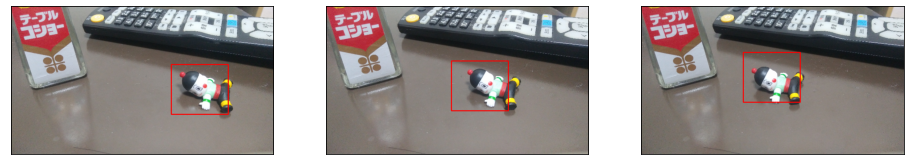

In [214]:
cap = np.array([img_rgb2,img_rgb3,img_rgb4])

# take first frame of the video
frame = cap[0]

# setup initial location of window
r,h,c,w = 170,140,470,160  # simply hardcoded the values
track_window = (c,r,w,h)

# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
hsv_roi =  cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5, 1)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
for i in range(3):
    frame = cap[i]

    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,10],1)

    # apply meanshift to get the new location
    ret, track_window = cv2.meanShift(dst, track_window, term_crit)

    # Draw it on image
    x,y,w,h = track_window
    img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
    
    ax[i].imshow(img2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [215]:
cap = cv2.VideoCapture("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/20181225_111451.avi")

# take first frame of the video
ret,frame = cap.read()

# setup initial location of window
r,h,c,w = 450,100,430,200  # simply hardcoded the values
track_window = (c,r,w,h)

# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
hsv_roi =  cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5, 1 )

while(1):
    ret ,frame = cap.read()

    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,10],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Draw it on image
        x,y,w,h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv2.imshow('img2',img2)

        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)

    else:
        break

cv2.destroyAllWindows()
cap.release()

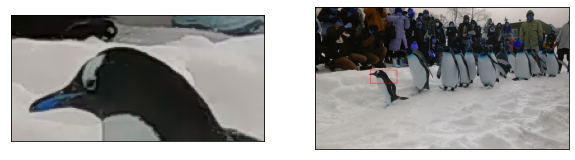

In [217]:
fig, ax = plt.subplots(1, 2, figsize=(10,  6))
ax[0].imshow(roi);
ax[0].set_xticks([]);
ax[0].set_yticks([]);

ax[1].imshow(img2);
ax[1].set_xticks([]);
ax[1].set_yticks([]);

###  Camshift

In [218]:
cap = cv2.VideoCapture("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/20181225_111451.avi")

# take first frame of the video
ret,frame = cap.read()

# setup initial location of window
r,h,c,w = 450,100,430,200  # simply hardcoded the values
track_window = (c,r,w,h)

# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
hsv_roi =  cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5, 1 )

while(1):
    ret ,frame = cap.read()

    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,10],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)

        # Draw it on image
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame,[pts],True, 255,2)
        cv2.imshow('img2',img2)

        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)

    else:
        break

cv2.destroyAllWindows()
cap.release()

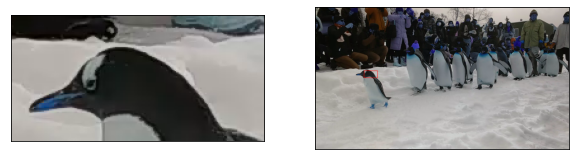

In [219]:
fig, ax = plt.subplots(1, 2, figsize=(10,  6))
ax[0].imshow(roi);
ax[0].set_xticks([]);
ax[0].set_yticks([]);

ax[1].imshow(img2);
ax[1].set_xticks([]);
ax[1].set_yticks([]);

In [289]:
http://clientver2.hatenablog.com/entry/2016/02/08/195712

357.57336

In [317]:
def tracking():
    #カメラ
    cap = cv2.VideoCapture(0)
    #パーティクルフィルタ初期化
    filter = ParticleFilter()
    filter.initialize()

    while True:
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        y, x = filter.filtering(gray)#トラッキング
        frame = cv2.circle(frame, (int(x), int(y)), 10, (0, 0, 255), -1)
        for i in range(filter.SAMPLEMAX):
            frame = cv2.circle(frame, (int(filter.X[i]), int(filter.Y[i])), 2, (0, 0, 255), -1)
        cv2.imshow("frame", frame)
        if cv2.waitKey(20) & 0xFF == 27:
            break
    cap.release()
    cv2.destroyAllWindows()

#パーティクルフィルタクラス
class ParticleFilter:
    def __init__(self):
        self.SAMPLEMAX = 1000
        self.height, self.width = 480, 640#フレーム画像のサイズ

    #パーティクル初期化
    #画像全体にまく
    def initialize(self):
        self.Y = np.random.random(self.SAMPLEMAX) * self.height
        self.X = np.random.random(self.SAMPLEMAX) * self.width

    #パーティクルの状態の更新　物体が適当な速さで適当に動くと仮定
    def modeling(self):
        self.Y += np.random.random(self.SAMPLEMAX) * 20 - 10
        self.X += np.random.random(self.SAMPLEMAX) * 20 - 10

    #重み正規化
    def normalize(self, weight):
        return weight / np.sum(weight)

    #パーティクルリサンプリング
    #重みに従ってパーティクルを選択
    #残ったパーティクルのインデックスを返す
    def resampling(self, weight):
        index = np.arange(self.SAMPLEMAX)
        sample = []

        for i in range(self.SAMPLEMAX):
            idx = np.random.choice(index, p=weight)
            sample.append(idx)

        return sample

    #尤度計算
    #画像の外に飛んでいったパーティクルは重み0
    #白い物体を仮定
    def calcLikelihood(self, image):
        mean, std = 250.0, 10.0
        intensity = []

        for i in range(self.SAMPLEMAX):
            y, x = self.Y[i], self.X[i]
            if y >= 0 and y < self.height and x >= 0 and x < self.width:
                intensity.append(image[int(y),int(x)])
            else:
                intensity.append(-1)

        weights = 1.0 / np.sqrt(2 * np.pi * std) * np.exp(-(np.array(intensity) - mean)**2 /(2 * std**2))
        weights[intensity == -1] = 0
        weights = self.normalize(weights)
        return weights

    #トラッキング開始
    #期待値を返す
    def filtering(self, image):
        self.modeling()
        weights = self.calcLikelihood(image)
        index = self.resampling(weights)
        self.Y = self.Y[index]
        self.X = self.X[index]
        
        return np.sum(self.Y) / float(len(self.Y)), np.sum(self.X) / float(len(self.X))

tracking()